In [1]:
from uuid import uuid4

from astropy.modeling import Fittable1DModel, Parameter
from astropy.modeling.models import Gaussian1D, Const1D, Shift
from astropy.modeling.fitting import LMLSQFitter, TRFLSQFitter, model_to_fit_params
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
from astropy.table import Table, vstack
from feadme.parser import Template
from feadme.compose import evaluate_disk_model#, jax_evaluate_disk_model
from collections import namedtuple
from itertools import product

/Users/nmearl/code/feadme/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-11 18:15:00 | DEBUG    | Initializing...
2025-04-11 18:15:00 | DEBUG    | Backend: cpu
2025-04-11 18:15:00 | DEBUG    | Device count: 2
2025-04-11 18:15:00 | DEBUG    | Device: cpu
2025-04-11 18:15:00 | DEBUG    | Local device count: 2


In [2]:
from feadme.utils import dict_to_namedtuple

class DiskProfileModel(Fittable1DModel):
    center = Parameter()
    inner_radius = Parameter()
    delta_radius = Parameter()
    inclination = Parameter()
    sigma = Parameter()
    q = Parameter()
    eccentricity = Parameter()
    apocenter = Parameter()
    scale = Parameter()
    offset = Parameter()

    def __init__(self, template, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self._template = dict_to_namedtuple("NTemplate", template.model_dump())

    def evaluate(self, x, *args):
        pars = {}
        for i, pn in enumerate(self.param_names):
            pars[f"{self._name}_{pn}"] = args[i].squeeze()

            if pn in ["inner_radius", "delta_radius", "sigma"]:
                pars[f"{self._name}_{pn}"] = 10 ** pars[f"{self._name}_{pn}"]

        pars[f"{self.name}_outer_radius"] = pars[f"{self.name}_inner_radius"] + pars[f"{self.name}_delta_radius"]
        del pars[f"{self.name}_delta_radius"]

        # pars = dict_to_namedtuple("NTParamMods", pars)
        # print(pars)

        return evaluate_disk_model(self._template, x, pars)[0]


class LineProfileModel(Fittable1DModel):
    center = Parameter()
    amplitude = Parameter()
    vel_width = Parameter()

    def __init__(self, template, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self._template = dict_to_namedtuple("NTemplate", template.model_dump())

    def evaluate(self, x, *args):
        pars = {}

        for i, pn in enumerate(self.param_names):
            pars[f"{self.name}_{pn}"] = args[i].squeeze()

        # pars = dict_to_namedtuple("NTParamMods", pars)
        # print(pars)

        return evaluate_disk_model(self._template, x, pars)[0]


In [3]:
from astropy.modeling.fitting import FittingWithOutlierRemoval
from astropy.stats import akaike_info_criterion_lsq
from astropy.stats import sigma_clip


def boostrap_uncertainties(model, fitter, rest_wave, flux, flux_err, n=1000):
    bs_res = {}

    for i in range(n):
        # Generate bootstrap sample
        indices = np.random.choice(len(flux), len(flux), replace=True)
        flux_sample = flux[indices]
        flux_err_sample = flux_err[indices]

        # Fit model to bootstrap sample
        fit_mod = fitter(model, rest_wave, flux_sample, weights=1/flux_err_sample, maxiter=10000)
        _, indices, _ = model_to_fit_params(fit_mod)
        param_names = np.array(fit_mod.param_names)

        for pn, pv in zip(param_names[indices], fit_mod.parameters[indices]):
            bs_res.setdefault(pn, []).append(pv)

    bs_tab = Table(bs_res)
    pr_tab = Table(
        {
            "name": [f"{cn}" for cn in bs_tab.colnames],
            "value": [model.parameters[model.param_names.index(cn)] for cn in bs_tab.colnames],
            "mean": [np.mean(bs_tab[cn]) for cn in bs_tab.colnames],
            "median": [np.median(bs_tab[cn]) for cn in bs_tab.colnames],
            "std": [np.std(bs_tab[cn]) for cn in bs_tab.colnames],
            "lower": [np.percentile(bs_tab[cn], 16) for cn in bs_tab.colnames],
            "upper": [np.percentile(bs_tab[cn], 84) for cn in bs_tab.colnames],
        }
    )

    return pr_tab


def run_fit(template, rest_wave, flux, flux_err):
    full_model = Const1D(amplitude=0, fixed={'amplitude': True}, name="base")

    for prof in template.disk_profiles:
        in_par_values = {}
        in_par_bounds = {}
        in_par_fixed = {}

        disk_temp = template.model_copy()
        disk_temp.disk_profiles = [prof]
        disk_temp.line_profiles = []

        for param in prof._independent():
            param_low = param.low
            param_high = param.high

            if param.name in ["inner_radius", "delta_radius", "sigma"]:
                param_low = np.log10(param_low)
                param_high = np.log10(param_high)

            in_par_bounds[param.name] = (
                param_low,
                param_high,
            )

            in_par_values[param.name] = (param_high + param_low) / 2

        for param in prof._fixed():
            in_par_values[param.name] = param.value
            in_par_fixed[param.name] = True

        disk_mod = DiskProfileModel(disk_temp, **in_par_values, name=prof.name, bounds=in_par_bounds,
                                    fixed=in_par_fixed)

        full_model += disk_mod

    for prof in template.line_profiles:
        in_par_values = {}
        in_par_bounds = {}
        in_par_fixed = {}
        in_par_tied = {}

        line_temp = template.model_copy()
        line_temp.disk_profiles = []
        line_temp.line_profiles = [prof]

        for param in prof._independent():
            in_par_bounds[param.name] = (
                param.low,
                param.high,
            )

            in_par_values[param.name] = (param.high + param.low) / 2

        for param in prof._fixed():
            in_par_values[param.name] = param.value
            in_par_fixed[param.name] = True

        for param in prof._shared():
            in_par_values[param.name] = (param.high + param.low) / 2
            in_par_tied[param.name] = lambda m, mn=param.shared, pn=param.name: getattr(m[mn], pn)

        line_mod = LineProfileModel(line_temp, **in_par_values, name=prof.name, bounds=in_par_bounds,
                                    fixed=in_par_fixed, tied=in_par_tied)

        full_model += line_mod

    full_model =  Shift(offset=0, bounds={"offset": (-20, 5)}, name="shift") | full_model

    _, indices, _ = model_to_fit_params(full_model)

    fitter = TRFLSQFitter()
    fit_mod = fitter(full_model, rest_wave, flux, weights=1/flux_err, maxiter=10000)
    # or_fit = FittingWithOutlierRemoval(fitter, sigma_clip, niter=3, sigma=3.0, masked=False)
    # fit_mod, mask = or_fit(full_model, rest_wave, flux, weights=1/flux_err, maxiter=10000)
    # pr_tab = boostrap_uncertainties(fit_mod, fitter, rest_wave, flux, flux_err)
    # pr_tab.pprint_all()

    # cov_matrix = fitter.fit_info['param_cov']
    # param_errors = np.sqrt(np.diag(cov_matrix))
    # param_names = np.array(fit_mod.param_names)[indices]
    #
    # print(list(zip(param_names, param_errors)))

    fit_flux = fit_mod(rest_wave)
    ssr = np.sum((fit_flux - flux) ** 2)
    aic = akaike_info_criterion_lsq(ssr, len(indices), rest_wave.shape[0])

    return aic, fit_mod


Processing ZTF18aamfryk


True redshift:  0.08071594173128677
halpha_disk_center=6565.137433394675
halpha_disk_inner_radius=2.7051699326018595
halpha_disk_delta_radius=3.623228072495046
halpha_disk_inclination=1.49635642576318
halpha_disk_sigma=3.0019711456970297
halpha_disk_q=0.5000000000000366
halpha_disk_eccentricity=0.3597111445710931
halpha_disk_apocenter=4.711721234540206
halpha_disk_scale=0.21050798330237172
halpha_narrow_amplitude=0.7520060782993996
halpha_narrow_vel_width=531.4996577126225
halpha_broad_amplitude=0.26983096982416255
halpha_broad_vel_width=3823.8463334792277
niir_narrow_center=6585.907391848046
niir_narrow_amplitude=0.8463831901212396
niil_narrow_center=6550.846411345484
niil_narrow_amplitude=0.30110617988194793
siir_narrow_center=6733.777091513581
siir_narrow_amplitude=0.3568918083299495
siil_narrow_center=6719.214294573435
siil_narrow_amplitude=0.38433717888384084
{'halpha_broad_amplitude': np.float64(0.26983096982416255),
 'halpha_broad_vel_width': np.float64

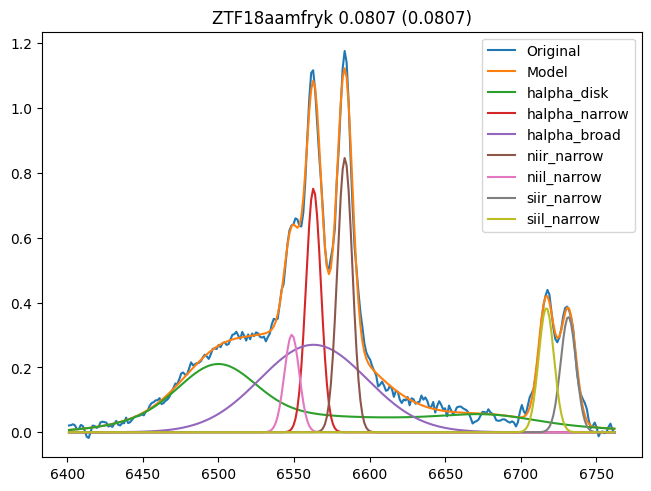

In [4]:
res_tab = None

for template_path in Path("/Users/nmearl/research/tde_agn_comparison/templates").glob("*.json"):
    if 'ZTF' not in str(template_path):
        continue

    if "ZTF18aamfryk" not in str(template_path):
        continue

    # if 'TDE' not in str(template_path) or 'zr' not in str(template_path):
    #     continue

    # if Path(f"/Users/nmearl/Downloads/agn_fits/{template_path.stem}.png").exists():
    #     continue

    print(f"Processing {template_path.stem}\n\n")

    with open(template_path, "r") as f:
        template = json.load(f)
        template = Template(**template)

    data = Table.read(template.data_path)

    wave = data['wave'].value
    flux = data['flux'].value
    flux_err = data['flux_err'].value
    rest_wave = wave / (1 + template.redshift)

    mask = [
        np.bitwise_and(rest_wave > m.lower_limit, rest_wave < m.upper_limit)
        for m in template.mask
    ]
    if len(mask) > 1:
        mask = np.bitwise_or(*mask)
    else:
        mask = mask[0]

    flux = flux[mask]
    wave = wave[mask]
    flux_err = flux_err[mask]
    rest_wave = rest_wave[mask]

    if len(flux) == 0:
        print(f"Skipping {template_path.stem} due to empty flux array.")
        continue

    # Setup results dictionary
    res_dict = {
        "name": [], "mjd": [], "aic": [],
        **{k.name: [] for k in template.disk_profiles + template.line_profiles},
    }

    prof_inds = {p.name: i for i, p in enumerate(template.disk_profiles + template.line_profiles)}

    # variations = [list(v) for v in product([0, 1], repeat=len(template.disk_profiles + template.line_profiles))][1:]
    #
    # # Always ensure halpha narrow is used
    # for i, prof in enumerate(template.disk_profiles + template.line_profiles):
    #     if prof.name == "halpha_narrow":
    #         variations = [v for v in variations if v[i] == 1]
    #
    # # Ensure niil and niir are used together
    # variations = [
    #     v for v in variations
    #     if ((v[prof_inds['niil_narrow']] == 1 and v[prof_inds['niir_narrow']] == 1) or
    #         (v[prof_inds['niil_narrow']] == 0 and v[prof_inds['niir_narrow']] == 0))]
    #
    # # Ensure siil and siir are used together
    # variations = [
    #     v for v in variations
    #     if ((v[prof_inds['siil_narrow']] == 1 and v[prof_inds['siir_narrow']] == 1) or
    #         (v[prof_inds['siil_narrow']] == 0 and v[prof_inds['siir_narrow']] == 0))]

    variations = [[1] * len(template.disk_profiles + template.line_profiles)]

    best_fit_aic = 0
    best_fit_mod = None

    for var in variations:
        var_temp = template.model_copy()

        var_temp.disk_profiles = [
            var_temp.disk_profiles[i]
            for i in range(len(template.disk_profiles))
            if bool(var[i])]

        var_temp.line_profiles = [
            var_temp.line_profiles[i]
            for i in range(len(template.line_profiles))
            if bool(var[len(template.disk_profiles) + i])]

        prof_names = [p.name for p in var_temp.disk_profiles + var_temp.line_profiles]
        shared_params = [pp.shared for p in var_temp.disk_profiles + var_temp.line_profiles for pp in p.shared]

        for prof in var_temp.line_profiles:
            for param in prof._shared():
                if param.shared not in prof_names:
                    param.shared = None

        aic, fit_mod = run_fit(var_temp, rest_wave, flux, flux_err)

        if aic < best_fit_aic or best_fit_aic == 0:
            best_fit_aic = aic
            best_fit_mod = fit_mod

        res_dict["name"].append(template.name)
        res_dict["mjd"].append(template.mjd)
        res_dict["aic"].append(aic)

        for prof in template.disk_profiles + template.line_profiles:
            if prof.name in [p.name for p in var_temp.disk_profiles + var_temp.line_profiles]:
                res_dict[prof.name].append(True)
            else:
                res_dict[prof.name].append(False)

    if res_tab is None:
        res_tab = Table(res_dict)
    else:
        res_tab = vstack([res_tab, Table(res_dict)])

    try:
        true_halpha_centroid = (best_fit_mod['halpha_narrow'].center.value * (1 + template.redshift)) - best_fit_mod['shift'].offset
        true_redshift = (true_halpha_centroid - 6562.819) / 6562.819
    except:
        true_redshift = template.redshift

    print("True redshift: ", true_redshift)

    fig, ax = plt.subplots(layout="constrained")

    ax.plot(rest_wave, flux, label='Original')
    ax.plot(rest_wave, best_fit_mod(rest_wave), label='Model')
    ax.set_title(f"{template.name} {template.redshift:.4f} ({true_redshift:.4f})")

    for sm in best_fit_mod:
        if sm.name in ["shift", "base"]:
            continue
        ax.plot(rest_wave, (best_fit_mod[0] | sm)(rest_wave), label=sm.name)

    ax.legend()

    fig.savefig(f"/Users/nmearl/Downloads/agn_fits/{template_path.stem}.png")
    # plt.close(fig)

    from pprint import pprint

    starters = {}

    indep_params = [
        f"{prof.name}_{param.name}" for prof in template.all_profiles for param in prof._independent()
    ]

    for sm in best_fit_mod:
        if sm.name in ["shift", "base"]:
            continue

        _, inds, _ = model_to_fit_params(sm)

        for pn, pv in zip(np.array(sm.param_names)[inds], sm.parameters[inds]):
            samp_name = f"{sm.name}_{pn}"
            print(f"{samp_name}={pv}")

            if samp_name in indep_params:
                if pn in ["inner_radius", "delta_radius", "sigma"]:
                    pv = 10 ** pv

                starters[samp_name] = pv

    pprint(starters)

            # for prof in template.disk_profiles:
            #     if prof.name == sm.name:
            #         for param in prof._independent():
            #             if param.name == pn:
            #                 if pn in ["inner_radius", "delta_radius", "sigma"]:
            #                     param.value = 10 ** pv
            #                 else:
            #                     param.value = pv
            #                 break
            #         else:
            #             print(f"Could not find {sm.name} in disk profiles")
            #
            # for prof in template.line_profiles:
            #     if prof.name == sm.name:
            #         for param in prof._independent():
            #             if param.name == pn:
            #                 param.value = pv
            #                 break
            #         else:
            #             print(f"Could not find {sm.name} in line profiles")

    # pprint(template.model_dump())

    break

    # Update template redshift and write out results
    # template.redshift = true_redshift

    # with open(template_path, "w") as f:
    #     json.dump(template.model_dump(), f, indent=4)


In [5]:
res_tab.to_pandas()

,name,mjd,aic,halpha_disk,halpha_narrow,halpha_broad,niir_narrow,niil_narrow,siir_narrow,siil_narrow
0,ZTF18aamfryk,None,-2214.824698,True,True,True,True,True,True,True


In [6]:
print(best_fit_mod)
best_fit_mod.bounds

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] | [1] + [2] + [3] + [4] + [5] + [6] + [7] + [8]
Components: 
    [0]: <Shift(offset=2.28041508, name='shift')>

    [1]: <Const1D(amplitude=0., name='base')>

    [2]: <DiskProfileModel(center=6565.13743339, inner_radius=2.70516993, delta_radius=3.62322807, inclination=1.49635643, sigma=3.00197115, q=0.5, eccentricity=0.35971114, apocenter=4.71172123, scale=0.21050798, offset=0., name='halpha_disk')>

    [3]: <LineProfileModel(center=6565.13743339, amplitude=0.75200608, vel_width=531.49965771, name='halpha_narrow')>

    [4]: <LineProfileModel(center=6565.13743339, amplitude=0.26983097, vel_width=3823.84633348, name='halpha_broad')>

    [5]: <LineProfileModel(center=6585.90739185, amplitude=0.84638319, vel_width=531.49965771, name='niir_narrow')>

    [6]: <LineProfileModel(center=6550.84641135, amplitude=0.30110618, vel_width=531.49965771, name='niil_narrow')>

    [7]: <LineProfileModel(center=673

{'offset_0': (-20.0, 5.0), 'amplitude_1': (None, None), 'center_2': (6557.819, 6567.819), 'inner_radius_2': (2.0, 3.6989700043360187), 'delta_radius_2': (2.6989700043360187, 4.0), 'inclination_2': (0.0, 1.5707963267948966), 'sigma_2': (2.3010299956639813, 4.0), 'q_2': (0.5, 4.0), 'eccentricity_2': (0.0, 1.0), 'apocenter_2': (0.0, 6.283185307179586), 'scale_2': (0.0, 1.2938937542700935), 'offset_2': (None, None), 'center_3': (None, None), 'amplitude_3': (0.0, 1.2938937542700935), 'vel_width_3': (10.0, 1000.0), 'center_4': (None, None), 'amplitude_4': (0.0, 1.2938937542700935), 'vel_width_4': (1000.0, 10000.0), 'center_5': (6578.46, 6588.46), 'amplitude_5': (0.0, 1.2938937542700935), 'vel_width_5': (None, None), 'center_6': (6543.05, 6553.05), 'amplitude_6': (0.0, 1.2938937542700935), 'vel_width_6': (None, None), 'center_7': (6725.81, 6735.81), 'amplitude_7': (0.0, 1.2938937542700935), 'vel_width_7': (None, None), 'center_8': (6711.44, 6721.44), 'amplitude_8': (0.0, 1.2938937542700935), 